In [7]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import itertools
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.nan)

pdata = pd.read_csv("../Data/preprocessed_final.csv")
# pdata = pdata.drop(["Unnamed: 0"], axis=1)
pdata['Conditie'] = pdata['Conditie'].map({'norm': 0,  'bril': 1})
# pdata

In [3]:
X = pdata.drop(['Conditie', 'SubjectID'], axis=1)
Y = pdata['Conditie']

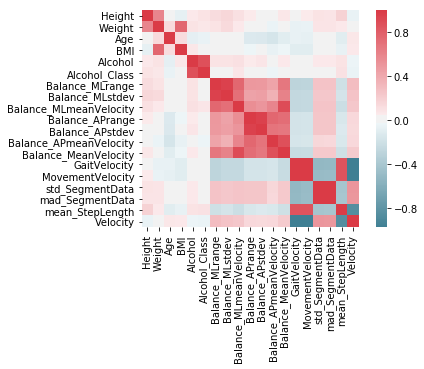

In [3]:
import seaborn as sns
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

In [5]:
#Splits data into training and validation according to specified ratio
def validation_split(data, ratio):
    sidlist = data['SubjectID'].unique()
    gdata = [data[data['SubjectID']==sid] for sid in sidlist]
    np.random.shuffle(gdata)
    N = len(gdata)
    training = gdata[:int(ratio*N)]
    validation = gdata[(int(ratio*N)):]
    return training,validation

# Converts the arrays in a list to one flattend dataframe
def flatten(data, variable_list):
    return pd.DataFrame(np.vstack(data), columns=variable_list)

def get_split_data(originaldata, variable_list, ratio):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Conditie', 'SubjectID'], axis=1)
    y_train = training['Conditie']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Conditie', 'SubjectID'], axis=1)
    y_test = validation['Conditie']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    return X_train, X_test, y_train, y_test

collist =  ['SubjectID', 'Conditie','mean_StepLength', 'GaitTime']
X_train, X_test, y_train, y_test = get_split_data(pdata, collist , 0.7)


X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)

X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=int)


In [6]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')


Accuracy of our model is equal 84.04 %.


In [8]:
from sklearn import svm 
from sklearn.svm import SVC
def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Conditie', 'SubjectID'], axis=1)
    y_train = training['Conditie']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Conditie', 'SubjectID'], axis=1)
    y_test = validation['Conditie']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    
    scaler = StandardScaler()

    # Fit on training set only.
    scaler.fit(X_train)

    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Make an instance of the Model
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
#     clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
#     clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
#     clf3 = GaussianNB()
#     clf4 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01)  

#     eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('dt', clf4)], voting='hard')
#     eclf1 = eclf1.fit(X_train, y_train)

#     y_pred = eclf1.predict(X_test)

    error = []
    for i in range(1, 40):  
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error.append(np.mean(pred_i != y_test)) 
    j = error.index(min(error)) +1
    
    clf1 = DecisionTreeClassifier(max_depth=4)
    clf2 = KNeighborsClassifier(n_neighbors=j)
    clf4 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
    clf5 = GaussianNB()
    eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('lg', clf4), ('nb', clf5)], voting='soft', weights=[2, 1, 2, 1])
    eclf = eclf.fit(X_train, y_train)

    y_pred = eclf.predict(X_test)

    return accuracy_score(y_test, y_pred) * 100


make_decisions(pdata, collist)

84.04255319148936

In [9]:
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'GaitTime', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')




mad_SegmentData, mean_StepLength: 85.81 %.
mean_StepLength, std_SegmentData: 84.83 %.
GaitTime, mean_StepLength, mad_SegmentData: 85.76 %.
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 84.33 %.
GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData: 84.39 %.
GaitTime, mean_StepLength, Height: 86.66 %.
GaitTime, mean_StepLength, Age: 85.72 %.
mean_StepLength, Height: 85.84 %.
mean_StepLength, Age: 85.1 %.
GaitTime, Height: 83.0 %.
std_SegmentData, Height: 71.09 %.
mad_SegmentData, Age: 72.02 %.
